In [1]:
from sklearn.neighbors import DistanceMetric
from math import radians
import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import scipy.sparse
import torch
from torch.utils.dlpack import to_dlpack, from_dlpack
from torch import Tensor
import torch_geometric
from torch_geometric.utils import to_undirected, is_undirected, convert
from torch_geometric.data import Data
from torch_geometric.utils.convert import from_networkx
#from torch_geometric.nn import GCNConv
import torch.nn.functional as F

def MAPELoss(output, target):
    return torch.mean(torch.abs((target - output) / target))  

In [2]:
cities_df = pd.DataFrame({
    'city':['bangalore','Mumbai','Delhi','kolkatta','chennai','bhopal'],
    'lat':[12.9716,19.076,28.7041,22.5726,13.0827,23.2599],
    'lon':[77.5946,72.877,77.1025,88.639,80.2707,77.4126],
    'x1':[20,35,24,33,35,18],
    'x2':[5,5,7,13,16,21],
    'y':[1200,1500,2000,1780,1450,3000]})
cities_df

,city,lat,lon,x1,x2,y
0,bangalore,12.9716,77.5946,20,5,1200
1,Mumbai,19.0760,72.8770,35,5,1500
2,Delhi,28.7041,77.1025,24,7,2000
3,kolkatta,22.5726,88.6390,33,13,1780
4,chennai,13.0827,80.2707,35,16,1450
5,bhopal,23.2599,77.4126,18,21,3000


In [3]:
cities_df['lat'] = np.radians(cities_df['lat'])
cities_df['lon'] = np.radians(cities_df['lon'])

In [4]:
dist = DistanceMetric.get_metric('haversine')

In [5]:
cities_df[['lat','lon']].to_numpy()

array([[0.22639713, 1.35428125],
       [0.33293901, 1.2719436 ],
       [0.50098105, 1.34569249],
       [0.39396619, 1.5470424 ],
       [0.22833619, 1.40098801],
       [0.40596184, 1.35110475]])

In [6]:
df = pd.DataFrame(dist.pairwise(cities_df[['lat','lon']].to_numpy())*6373,  columns=cities_df.city.unique(), index=cities_df.city.unique())
df

,bangalore,Mumbai,Delhi,kolkatta,chennai,bhopal
bangalore,0.000000,845.628325,1750.664163,1582.525176,290.263116,1144.527052
Mumbai,845.628325,0.000000,1153.629733,1683.203283,1033.479952,661.621084
Delhi,1750.664163,1153.629733,0.000000,1341.809060,1768.206317,606.349722
kolkatta,1582.525176,1683.203283,1341.809060,0.000000,1377.283504,1152.404181
chennai,290.263116,1033.479952,1768.206317,1377.283504,0.000000,1171.476936
bhopal,1144.527052,661.621084,606.349722,1152.404181,1171.476936,0.000000


/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:579: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  if not cb.iterable(width):
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:585: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  and cb.iterable(edge_color) \
/Users/shao/anaconda3/lib/python3.7/site-packages/networkx/drawing/nx_pylab.py:595: MatplotlibDeprecationWarning: 
The iterable function was deprecated in Matplotlib 3.1 and will be removed in 3.3. Use np.iterable instead.
  for c in edge_color]):


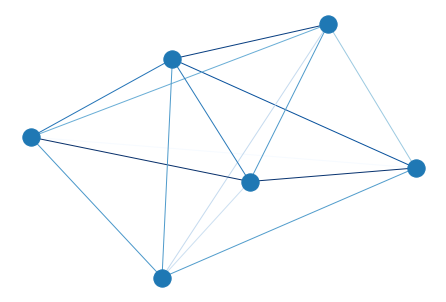

In [7]:
G = nx.from_numpy_matrix(df.values)
nx.draw(G, edge_color = [i[2]['weight'] for i in G.edges(data=True)], edge_cmap = plt.cm.Blues)

In [8]:
D = df.values

In [9]:
D[D <1200] = 1
D[D >=1200] = 0

In [10]:
D

array([[1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 0., 1., 1.],
       [0., 1., 1., 0., 0., 1.],
       [0., 0., 0., 1., 0., 1.],
       [1., 1., 0., 0., 1., 1.],
       [1., 1., 1., 1., 1., 1.]])

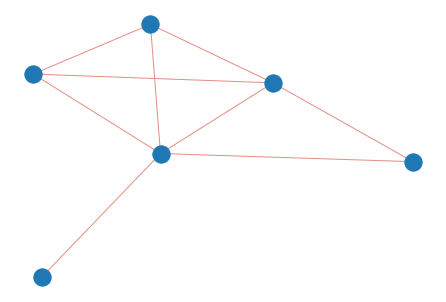

In [11]:
G = nx.from_numpy_matrix(D)
nx.draw(G, edge_color = '#E28F83')

In [12]:
a = torch.tensor([[1.4335,-1.0990,-0.8586],[2.1553,2.2728,-0.8020],[1.0524,0.1599,-0.0374]])

In [13]:
a

tensor([[ 1.4335, -1.0990, -0.8586],
        [ 2.1553,  2.2728, -0.8020],
        [ 1.0524,  0.1599, -0.0374]])

In [14]:
a = torch.tensor([[0.9041,0.0196],[-0.3108,-2.4423],[-0.4821,1.059]])
b = torch.tensor([[-2.1763,-0.4713],[-0.6986,1.3702]])
torch.cdist(a, b, p=2)

tensor([[3.1193, 2.0959],
        [2.7138, 3.8322],
        [2.2830, 0.3791]])

In [15]:
x = torch.tensor([[2,1],[5,6],[3,7],[12,0]], dtype=torch.float)
y = torch.tensor([0,1,0,1], dtype=torch.float)

In [16]:
edge_index = from_networkx(G).edge_index
edge_index

tensor([[0, 0, 0, 0, 1, 1, 1, 1, 1, 2, 2, 2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5],
        [0, 1, 4, 5, 0, 1, 2, 4, 5, 1, 2, 5, 3, 5, 0, 1, 4, 5, 0, 1, 2, 3, 4, 5]])

In [17]:
x = torch.tensor(cities_df[['x1','x2']].values, dtype=torch.float)
x

tensor([[20.,  5.],
        [35.,  5.],
        [24.,  7.],
        [33., 13.],
        [35., 16.],
        [18., 21.]])

In [18]:
y = torch.tensor(cities_df[['y']].values, dtype=torch.float)
y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])

In [19]:
data = Data(x=x, y=y, edge_index=edge_index)

In [20]:
data

Data(edge_index=[2, 24], x=[6, 2], y=[6, 1])

In [21]:
from torch.utils.data import DataLoader
loader = DataLoader(data, batch_size=512, shuffle=True)

In [79]:
import torch
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super(GCNConv, self).__init__(aggr='add')
        self.lin = torch.nn.Linear(in_channels, out_channels)

    def forward(self, x, edge_index):
        # Step 1: Add self-loops
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Multiply with weights
        x = self.lin(x)

        # Step 3: Calculate the normalization
        row, col = edge_index
        deg = degree(row, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4: Propagate the embeddings to the next layer
        return self.propagate(edge_index, size=(x.size(0), x.size(0)), x=x,
                              norm=norm)

    def message(self, x_j, norm):
        # Normalize node features.
        return norm.view(-1, 1) * x_j

In [87]:
import torch
import torch.nn.functional as F

class Net(torch.nn.Module):
    def __init__(self, dataset):
        super(Net, self).__init__()
        self.conv1 = GCNConv(dataset.num_node_features, 2)
        self.conv2 = GCNConv(2, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index

        x = self.conv1(x, edge_index)
        x = F.relu(x)
        x = F.dropout(x, training=self.training)
        x = self.conv2(x, edge_index)

        return F.log_softmax(x, dim=1)

In [88]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Net(data).to(device)
data = data.to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

In [89]:
num_epochs = 1000

model.train()
for epoch in range(num_epochs):
    
    out = model(data)
    loss = MAPELoss(out, data.y)
    loss.backward()
    
    optimizer.zero_grad()
  
    optimizer.step()
    
    # Print the progress
    if (epoch+1) % 100 == 0:
        print('Epoch [{}/{}], Loss: {:.4f}'.format(epoch+1, num_epochs, loss.item()))

Epoch [100/1000], Loss: 1.0000
Epoch [200/1000], Loss: 1.0000
Epoch [300/1000], Loss: 1.0000
Epoch [400/1000], Loss: 1.0000
Epoch [500/1000], Loss: 1.0000
Epoch [600/1000], Loss: 1.0000
Epoch [700/1000], Loss: 1.0000
Epoch [800/1000], Loss: 1.0000
Epoch [900/1000], Loss: 1.0000
Epoch [1000/1000], Loss: 1.0000


In [90]:
model

Net(
  (conv1): GCNConv(
    (lin): Linear(in_features=2, out_features=2, bias=True)
  )
  (conv2): GCNConv(
    (lin): Linear(in_features=2, out_features=1, bias=True)
  )
)

In [71]:
out

tensor([[0.],
        [0.],
        [0.],
        [0.],
        [0.],
        [0.]], grad_fn=<LogSoftmaxBackward>)

In [49]:
data.y

tensor([[1200.],
        [1500.],
        [2000.],
        [1780.],
        [1450.],
        [3000.]])